# Set-up

In [1]:
import pandas as pd
import numpy as np
import muon as mu
from muon import atac as ac
import scanpy as sc
import scanpy.external as sce
import os
import matplotlib.pyplot as plt
import seaborn as sns

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir("/cellar/users/aklie/data/datasets/neurips2021_small")

# Load and inspect data

In [3]:
mdata = mu.read_h5mu("small.h5mu")
mdata

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py39/lib/python3.9/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


MuData object with n_obs × n_vars = 123 × 8704
  obs:	'celltype', 'batch', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker'
  2 modalities
    atac:	123 x 8192
      obs:	'pseudotime_order'
      obsm:	'X_lsi', 'X_umap'
      layers:	'counts'
    rna:	123 x 512
      obs:	'pseudotime_order'
      var:	'gene_id'
      obsm:	'X_pca', 'X_umap'
      layers:	'counts'

In [4]:
with mu.set_options(display_style="html", display_html_expand=0b000):
    display(mdata)

atac:pseudotime_order,float32,"0.91,0.93,0.56,0.07,0.02,0.68,1.00,0.52,0.76,0.95,..."
rna:pseudotime_order,float32,"0.91,0.93,0.32,0.05,0.07,0.45,0.98,0.28,0.76,0.99,..."
celltype,category,"Erythroblast,Erythroblast,MK/E prog,HSC,HSC,Proery..."
batch,category,"s1d1,s1d1,s1d1,s1d1,s1d1,s1d1,s1d1,s1d1,s1d1,s1d1,..."
Samplename,category,"site1_donor1_multiome,site1_donor1_multiome,site1_..."
Site,category,"site1,site1,site1,site1,site1,site1,site1,site1,si..."
DonorNumber,category,"donor1,donor1,donor1,donor1,donor1,donor1,donor1,d..."
Modality,category,"multiome,multiome,multiome,multiome,multiome,multi..."
VendorLot,int64,"3054455,3054455,3054455,3054455,3054455,3054455,30..."
DonorID,int64,"15078,15078,15078,15078,15078,15078,15078,15078,15..."
DonorAge,int64,"34,34,34,34,34,34,34,34,34,34,35,35,35,35,35,35,35..."


In [8]:
# Drop unused cell_type categories
mdata.obs["celltype"] = mdata.obs["celltype"].cat.remove_unused_categories()

<Axes: >

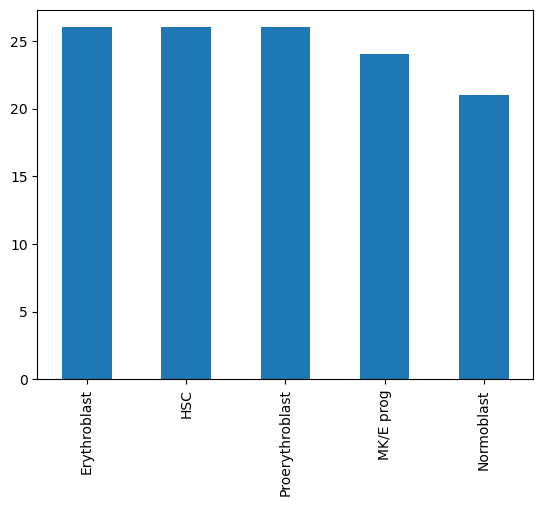

In [9]:
# Barplot of celltype distribution
mdata.obs["celltype"].value_counts().plot(kind="bar")

<Axes: >

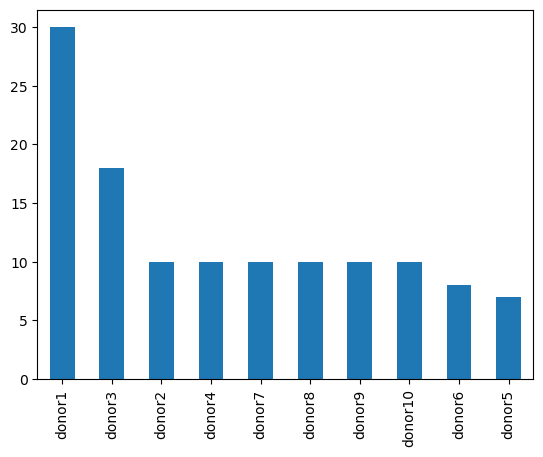

In [10]:
# Barplot of donor distribution
mdata.obs["DonorNumber"].value_counts().plot(kind="bar")

# Explore data

In [11]:
# Extract
rna = mdata.mod['rna'].copy()
atac = mdata.mod['atac'].copy()

## ATAC

In [12]:
# Use ScanPy to calculate metrics
bc_metrics, peak_metrics = sc.pp.calculate_qc_metrics(
    atac,
    expr_type="counts",
    var_type="peaks",
    layer="counts",
    inplace=False,
)

/cellar/users/aklie/.local/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


### Peaks

In [13]:
# Save peaks as bed file
peaks = mdata.mod["atac"].var_names
peaks = peaks.str.split("-", expand=True).to_frame()
peaks.columns = ["chr", "start", "end"]
peaks.reset_index(drop=True, inplace=True)
peaks.to_csv("peaks.bed", sep="\t", index=False, header=False)

In [14]:
# Merge peak_metrics with peaks and save as tsv
peaks.set_index(atac.var_names, inplace=True)
peak_metrics = peaks.join(peak_metrics)
peak_metrics.to_csv("peak_metrics.tsv", sep="\t")

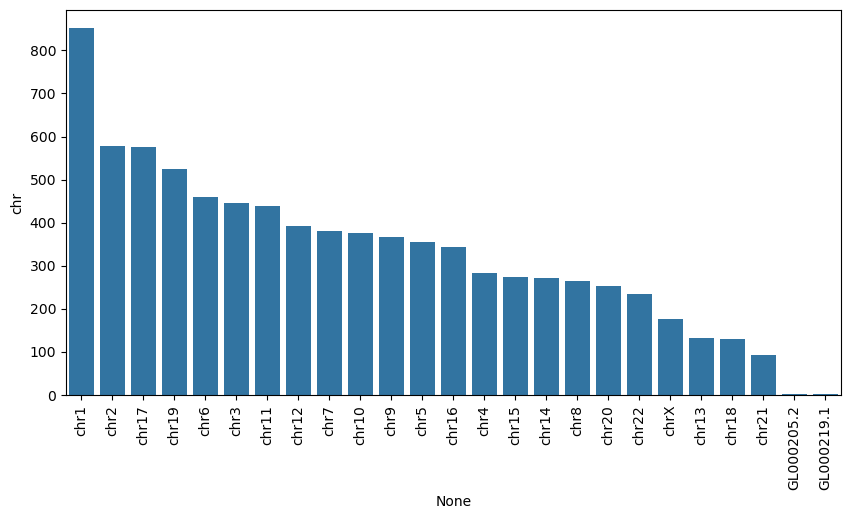

In [15]:
# Plot distribution of peaks across chromosomes
fig, ax = plt.subplots(figsize=(10, 5))
order = peak_metrics["chr"].value_counts().index
sns.barplot(
    x=peak_metrics["chr"].value_counts().index,
    y=peak_metrics["chr"].value_counts(),
    order=order,
    ax=ax,
)
plt.xticks(rotation=90);

<Axes: xlabel='total_counts', ylabel='Count'>

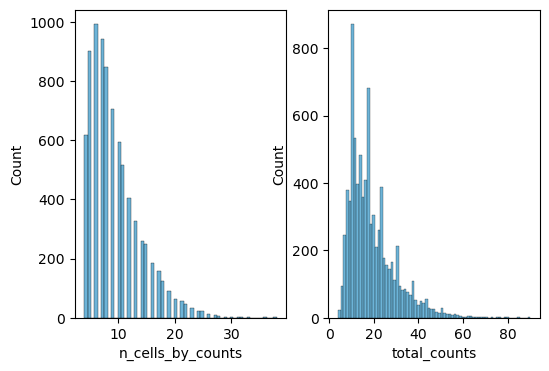

In [18]:
# Plot conuts in peaks, number of cells with counts in peaks
fig, ax = plt.subplots(1, 2, figsize=(6, 4))
sns.histplot(peak_metrics["n_cells_by_counts"], ax=ax[0], color="#3c9bcb")
sns.histplot(peak_metrics["total_counts"], ax=ax[1], color="#3c9bcb")

### Barcodes

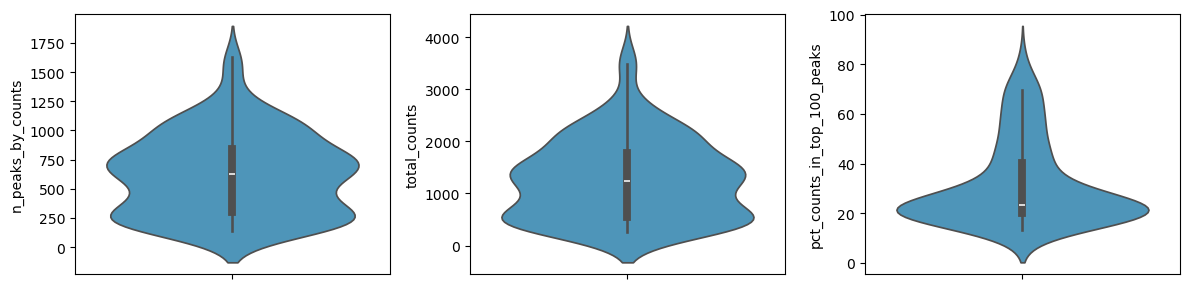

In [17]:
# Plot n_peaks_by_counts, total_counts and pct_counts in top_100_peaks color nice slightly light blue
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
sns.violinplot(y=bc_metrics["n_peaks_by_counts"], ax=ax[0], color="#3c9bcb")
sns.violinplot(y=bc_metrics["total_counts"], ax=ax[1], color="#3c9bcb")
sns.violinplot(y=bc_metrics["pct_counts_in_top_100_peaks"], ax=ax[2], color="#3c9bcb")
plt.tight_layout()

## RNA

In [19]:
# Use ScanPy to calculate metrics
bc_metrics, gene_metrics = sc.pp.calculate_qc_metrics(
    rna,
    expr_type="counts",
    var_type="genes",
    layer="counts",
    inplace=False,
)

### Genes

In [20]:
# Save as tsv
gene_metrics.to_csv("gene_metrics.tsv", sep="\t")

<Axes: xlabel='total_counts', ylabel='Count'>

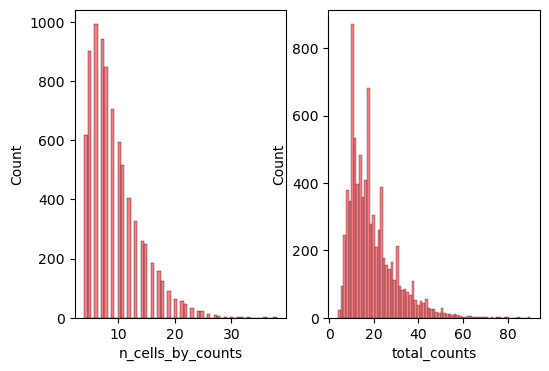

In [21]:
# Plot conuts in gene, number of cells with counts in gene
fig, ax = plt.subplots(1, 2, figsize=(6, 4))
sns.histplot(peak_metrics["n_cells_by_counts"], ax=ax[0], color="#f25159")
sns.histplot(peak_metrics["total_counts"], ax=ax[1], color="#f25159")

### Barcodes

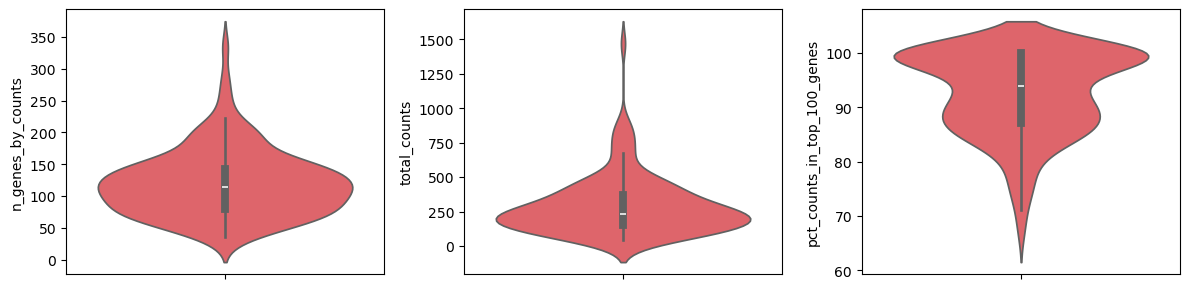

In [84]:
# Plot n_genes_by_counts, total_counts and pct_counts in top_100_genes
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
sns.violinplot(y=bc_metrics["n_genes_by_counts"], ax=ax[0], color="#f25159")
sns.violinplot(y=bc_metrics["total_counts"], ax=ax[1], color="#f25159")
sns.violinplot(y=bc_metrics["pct_counts_in_top_100_genes"], ax=ax[2], color="#f25159")
plt.tight_layout()

# Process data

In [234]:
n_hvg = 2048
n_downsample = 0

In [237]:
# Save counts in layers
rna.layers["counts"] = rna.X.copy()
atac.layers["counts"] = atac.X.copy()

In [238]:
# Normalize
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)
ac.pp.tfidf(atac, scale_factor=1e4)

In [200]:
# RNA hvg
sc.pp.highly_variable_genes(rna)
hvg = rna.var.sort_values('highly_variable', ascending=False).head(n_hvg).index
rna = rna[:, hvg].copy()

In [201]:
# ATAC hvg
sc.pp.highly_variable_genes(atac)
hvg = atac.var.sort_values('highly_variable', ascending=False).head(n_hvg * 16).index
atac = atac[:, hvg].copy()

In [239]:
# Check
rna.shape, atac.shape

((123, 512), (123, 8192))

In [240]:
# PCA
rna.layers['norm'] = rna.X.copy()
sc.pp.scale(rna, max_value=10)
sc.tl.pca(rna, svd_solver='arpack')
rna.X = rna.layers['norm'].copy()
del rna.layers['norm']

In [241]:
# UMAP
sc.pp.neighbors(rna)
sc.tl.umap(rna)

In [242]:
# Clustering
sc.tl.leiden(rna, resolution=0.5, key_added='leiden_0.5')

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


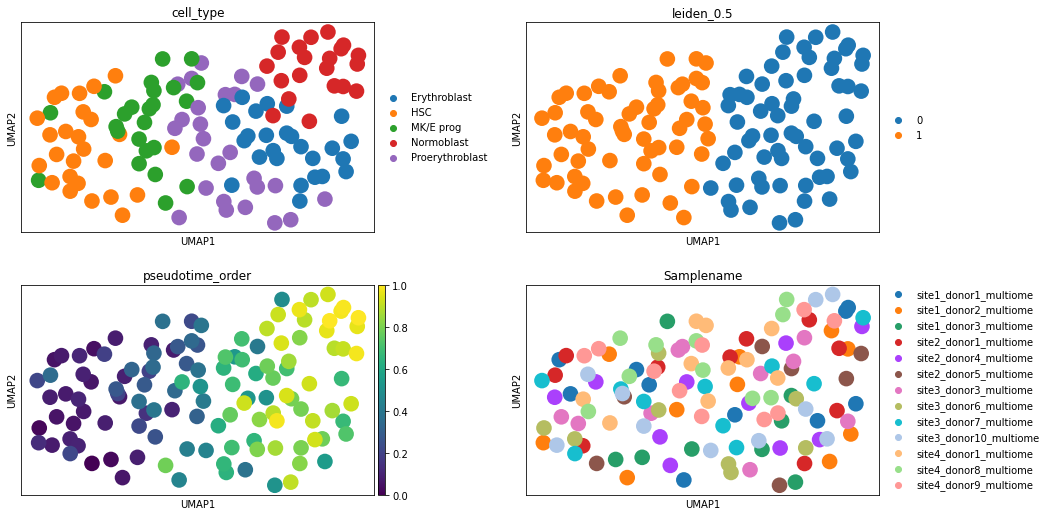

In [243]:
# Plot
rna.obs["cell_type"] = mdata.obs["celltype"].copy()
rna.obs["Samplename"] = mdata.obs["Samplename"].copy()
sc.pl.umap(rna, color=["cell_type", "leiden_0.5", "pseudotime_order", "Samplename"], wspace=0.3, ncols=2)

In [244]:
# LSI
atac.layers['norm'] = atac.X.copy()
ac.tl.lsi(atac)
atac.obsm['X_lsi'] = atac.obsm['X_lsi'][:, 1:]
atac.varm["LSI"] = atac.varm["LSI"][:, 1:]
atac.X = atac.layers['norm'].copy()
del atac.layers['norm']
del atac.uns

In [245]:
# UMAP
sc.pp.neighbors(atac, use_rep="X_lsi")
sc.tl.umap(atac)

In [246]:
# Clustering
sc.tl.leiden(atac, resolution=0.5, key_added='leiden_0.5')

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


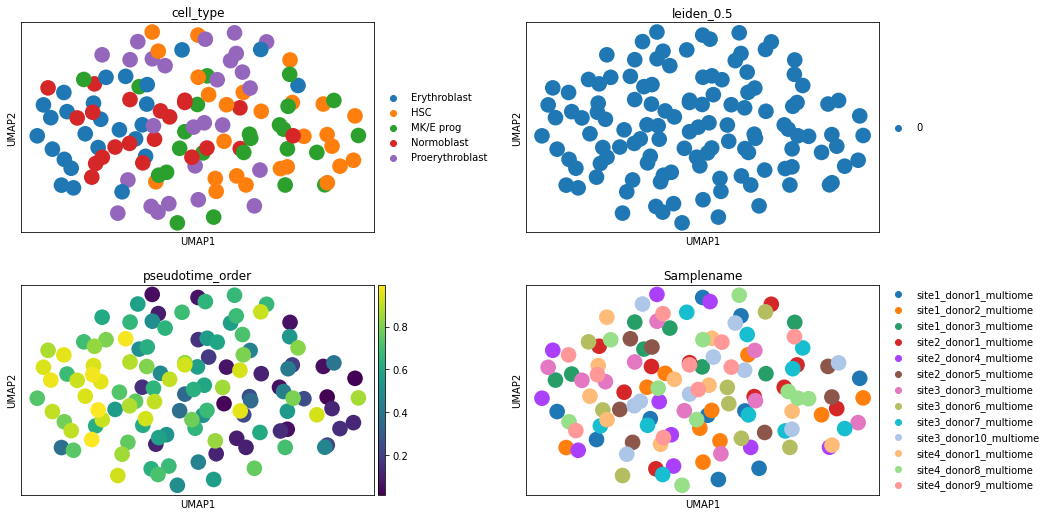

In [247]:
# Plot
atac.obs["cell_type"] = mdata.obs["celltype"].copy()
atac.obs["Samplename"] = mdata.obs["Samplename"].copy()
sc.pl.umap(atac, color=["cell_type", "leiden_0.5", "pseudotime_order", "Samplename"], wspace=0.3, ncols=2)

## Joint embedding

In [248]:
# Update mdata
mdata.mod['rna'] = rna
mdata.mod['atac'] = atac
mdata.update()

In [249]:
# WNN
mu.pp.neighbors(mdata, key_added='wnn')

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/pynndescent/pynndescent_.py:339: NumbaWarning: Cannot cache compiled function "init_rp_tree" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_rp_tree(data, dist, current_graph, leaf_array)
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/pynndescent/pynndescent_.py:341: NumbaWarning: Cannot cache compiled function "init_random" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  init_random(n_neighbors, data, current_graph, dist, rng_state)
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/pynndescent/pynndescent_.py:351: NumbaWarning: Cannot cache compiled function "process_candidates" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  nn_descent_internal_low_memory_parallel(
/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/pyt

: 

: 

In [ ]:
# UMAP on WNN
mu.tl.umap(mdata, neighbors_key='wnn')

In [ ]:
# Leiden on WNN
sc.tl.leiden(mdata, resolution=0.5, neighbors_key='wnn', key_added='leiden_wnn')

/cellar/users/aklie/opt/miniconda3/envs/scverse-lite-py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


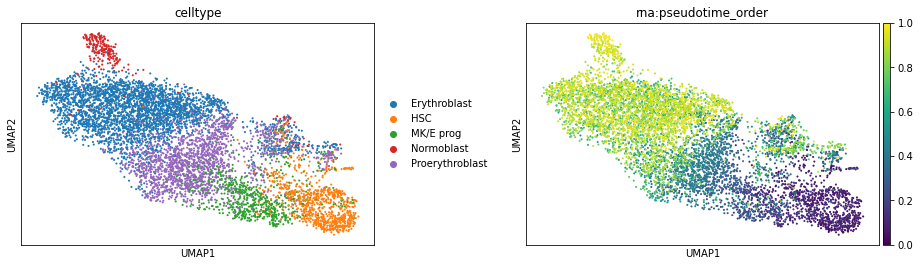

In [ ]:
# Plot joint embedding
sc.pl.umap(mdata, color=['celltype', 'rna:pseudotime_order'], wspace=0.3, ncols=2)

# Clean and save object

In [ ]:
# Remove any cells with no RNA or ATAC
mdata = mdata[mdata.mod['rna'].layers["counts"].sum(axis=1) > 0].copy()
mdata = mdata[mdata.mod['atac'].layers["counts"].sum(axis=1) > 0].copy()

In [ ]:
# Double check
(mdata.mod['atac'].layers["counts"].sum(axis=1) == 0).sum(), (mdata.mod['rna'].layers["counts"].sum(axis=1) == 0).sum()

(0, 0)

In [ ]:
# Clean
del mdata.obsp
del rna.var['mean']
del rna.var['std']
del rna.uns
del rna.varm
del rna.obsp
del atac.uns
del atac.varm
del atac.obsp

In [ ]:
# Check
rna, atac

(AnnData object with n_obs × n_vars = 7006 × 2048
     obs: 'pseudotime_order', 'leiden_0.5', 'cell_type', 'Samplename'
     var: 'gene_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     obsm: 'X_pca', 'X_umap'
     layers: 'counts',
 AnnData object with n_obs × n_vars = 7006 × 32768
     obs: 'pseudotime_order', 'leiden_0.5', 'cell_type', 'Samplename'
     var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     obsm: 'X_lsi', 'X_umap'
     layers: 'counts')

In [ ]:
# Check it
mdata.mod['rna'] = rna
mdata.mod['atac'] = atac

In [ ]:
# Update
mdata.update()

In [179]:
# Save
mdata.write("annotation/2023_12_05/mdata.h5mu")

# DONE!

---